In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.spatial import distance
from sklearn.decomposition import PCA
import math
from sklearn import preprocessing  # to normalise existing X
import random
from scipy.spatial.distance import pdist,squareform
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
from sklearn.decomposition import KernelPCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn import mixture
from sklearn.manifold import TSNE, MDS
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import LocallyLinearEmbedding, trustworthiness
from sklearn.preprocessing import StandardScaler

### Functions

In [2]:
def mds_reduction(data, target_dimension):
  return pd.DataFrame(MDS(n_components=target_dimension,eps=1e-4,n_init=15).fit_transform(data))
#PCA get principal components Functions
def get_pca(x):
    pca = PCA(n_components = d)
    pca.fit_transform(x)
    print(pca.explained_variance_ratio_)
    return pca.explained_variance_ratio_, pca.components_
#Identifying Components with small Eigenvalue
THRESHOLD = 0.99
def find_normal_vectors(eigens, vectors):
  res = sum(eigens)
  current = 0
  normal_vectors = []
  for i in range(0,len(eigens)):
    current += eigens[i]
    if current/res > THRESHOLD:
      for j in range(i+1,len(eigens)):
        normal_vectors.append(vectors[j])
      break
  return normal_vectors
def normalized(X, c):
  for i in range(len(X)):
    X.iloc[i]-= c
  return preprocessing.normalize(X)
def variance(data):
  mean = sum(data) / len(data)
  deviations = [(x - mean) ** 2 for x in data]
  variance = sum(deviations) / len(data)
  return variance
def get_reduced(X, target_dimension, reduction_type):
  X_transformed = []
  if reduction_type == 'iso':
    embedding = Isomap(n_components=target_dimension, n_neighbors=10)
    X_transformed = embedding.fit_transform(X)
  elif reduction_type == 'pca':
    transformer = PCA(n_components=target_dimension)
    X_transformed = transformer.fit_transform(X)
  elif reduction_type == 'k-pca':
    transformer = KernelPCA(n_components=target_dimension, kernel='rbf')
    X_transformed = transformer.fit_transform(X)
  elif reduction_type == 'tsne':
    X_transformed = TSNE(n_components=target_dimension, learning_rate='auto', init='pca').fit_transform(X)
  elif reduction_type == 'mds':
    X_transformed = mds_reduction(X,target_dimension)
  elif reduction_type == 'LLE':
    X_transformed = LocallyLinearEmbedding(n_components=target_dimension, n_neighbors=30).fit_transform(X)
  return X_transformed
def get_cluster(X, num_cluster, cluster_type):
  if cluster_type == 'GMM':
    model = mixture.GaussianMixture(n_components=num_cluster, covariance_type='full', n_init=100)
    model.fit(X)
    labels = model.predict(X)
  elif cluster_type == 'k-means':
    model=KMeans(n_clusters=num_cluster, n_init=10, max_iter=10000)
    model.fit(X)
    labels = model.predict(X)
  elif cluster_type == 'HS':
    model = AgglomerativeClustering(n_clusters=num_cluster, linkage='single')
    model.fit(X)
    labels = model.labels_
  elif cluster_type == 'H':
    model = AgglomerativeClustering(n_clusters=num_cluster, linkage='single', affinity='cosine')
    model.fit(X)
    labels = model.labels_
  elif cluster_type == 'spectral':
    model = SpectralClustering(assign_labels='discretize', n_clusters=num_cluster, random_state=77, n_init=1)
    model.fit(X)
    labels = model.labels_
  elif cluster_type == 'custom':
    td = 2
    p = pd.DataFrame(LocallyLinearEmbedding(n_components=td, n_neighbors=20).fit_transform(StandardScaler().fit_transform(X)), columns=[j for j in range(td)])
    return get_cluster(p, cluster_type='GMM', num_cluster=num_cluster)
  elif cluster_type == 'custom3d':
    td = 3
    p = pd.DataFrame(LocallyLinearEmbedding(n_components=td, n_neighbors=20).fit_transform(StandardScaler().fit_transform(X)), columns=[j for j in range(td)])
    return get_cluster(p, cluster_type='GMM', num_cluster=num_cluster)
  elif cluster_type == 'custom50':
    td = 2
    p = pd.DataFrame(LocallyLinearEmbedding(n_components=td, n_neighbors=50).fit_transform(StandardScaler().fit_transform(X)), columns=[j for j in range(td)])
    return get_cluster(p, cluster_type='GMM', num_cluster=num_cluster)
  return labels
# Epsilon for DBSCAN
def show_distance_graph(X):
  neigh = NearestNeighbors(n_neighbors=2)
  nbrs = neigh.fit(X)
  distances, indices = nbrs.kneighbors(X)
  # Plotting K-distance Graph
  distances = np.sort(distances, axis=0)
  distances = distances[:,1]
  print(distances[-60:])
  plt.figure(figsize=(10,5))
  plt.plot(distances)
  plt.title('K-distance Graph',fontsize=20)
  plt.xlabel('Data Points sorted by distance',fontsize=14)
  plt.ylabel('Epsilon',fontsize=14)
  plt.show()
  #Visualization in 4D
# %matplotlib notebook
def visualize_4d(frame, hot=True):
  fig = plt.figure(figsize=(7, 7))
  ax = fig.add_subplot(111, projection='3d')
  x = np.array(frame.iloc[:,0])
  if len(frame.columns) > 1:
    y = np.array(frame.iloc[:,1])
  if len(frame.columns) > 2:
    z = np.array(frame.iloc[:,2])
  if len(frame.columns) == 1:
    img = ax.scatter(x, x, s=2)
  if len(frame.columns) == 2:
    img = ax.scatter(x, y, s=2)
  elif len(frame.columns) == 3:
    img = ax.scatter(x, y, z, s=2)
  else:
    c = np.array(frame.iloc[:,3])
    if hot:
      img = ax.scatter(x, y, z, c=c, cmap=plt.hot(), s=2)
    else:
      img = ax.scatter(x, y, z, c=c, cmap='viridis', s=2)
  plt.show()
def getIntrinsicDimension(X):
  scores = []
  for i in [1, 2]:
    Xt = LocallyLinearEmbedding(n_components=i,n_neighbors=20).fit_transform(X)
    scores.append(trustworthiness(X, Xt, n_neighbors=100))
  print(scores)

def merge(X, col, val_list):
  def get_col(row):
    for ind in range(len(val_list)):
      if row[col] in val_list[ind]:
        return 100 + ind
    return row[col]
  X[col] = X.apply(get_col, axis=1)
  X[col] = LabelEncoder().fit_transform(X[col])
  X[col] -= 1
  return X

### Open Input

In [3]:
# Input
file = open('./R33.txt','r')
d,n,m,k,p = list(map(int,file.readline().split()))
k_list = list(map(int,file.readline().split()))
ar=[]
for i in range(0,n):
  ar.append(list(map(float,file.readline().split())))
df= pd.DataFrame(ar)
df.describe()

0             1             2             3             4  \
count  69221.000000  69221.000000  69221.000000  69221.000000  69221.000000   
mean     905.158992    -70.017255     32.236449   -123.276994     21.294569   
std      540.365119     76.053361     39.667027    101.359423    116.518661   
min    -1172.921709   -206.641163   -133.002538   -343.624310   -293.047453   
25%      428.973573   -145.966305      6.240470   -222.388566   -103.125315   
50%      881.990844    -52.894399     30.183098    -98.044784     50.747406   
75%     1371.388702     -6.420930     59.329963    -52.104697     93.513607   
max     1822.612790    190.067632    144.406354    264.516816    291.845317   

                  5             6             7             8             9  
count  69221.000000  69221.000000  69221.000000  69221.000000  69221.000000  
mean      42.555045    198.503398    155.207426     16.016805     -0.323530  
std       43.216778     76.900531     75.204474     86.890652     35.867962  
min     -145.096580   -225.161628   -223.082943   -245.459239   -135.787534  
25%       13.779101    165.987728    101.728444    -41.695997    -24.104470  
50%       36.738022    210.412062    138.063987     27.023397     -0.650539  
75%       66.018942    240.250700    194.615456     74.162302     20.282032  
max      179.936749    366.543216    370.356126    242.109565    138.051027

### Finding Submanifolds

count    69221.000000
mean         9.903960
std          5.791666
min         -1.000000
25%          5.000000
50%         11.000000
75%         14.000000
max         19.000000
Name: manifold, dtype: float64


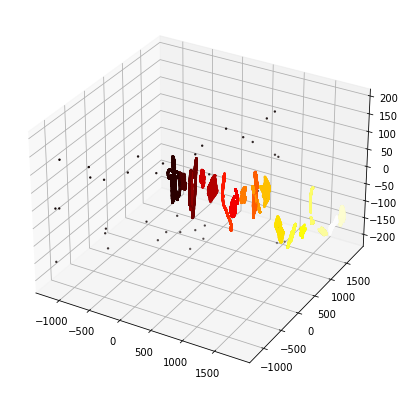

In [4]:
#DBSCAN
EPS = 0.7
MIN_SAMPLES = 6
model_name = 'dbscan'
res = pd.DataFrame(StandardScaler(with_mean=False).fit_transform(df), columns=[i for i in range(d)])
res.describe()
model = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
model.fit(res[[i for i in range(0,d)]])
df['manifold'] = model.labels_
print(df['manifold'].describe())
visualize_4d(df[[0,0,1,'manifold']])

0


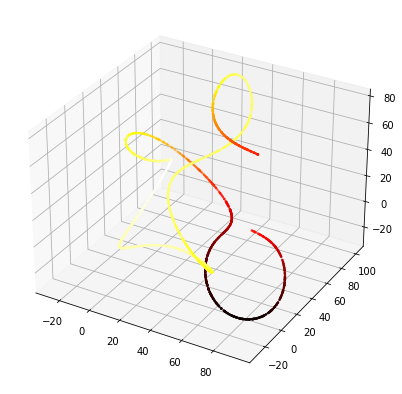

1


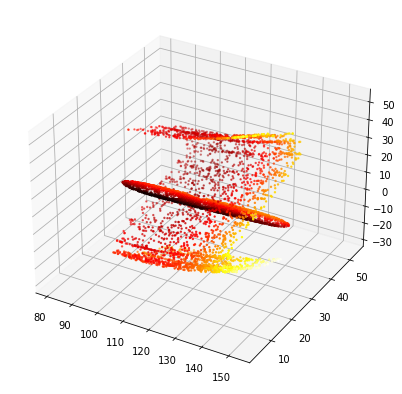

2


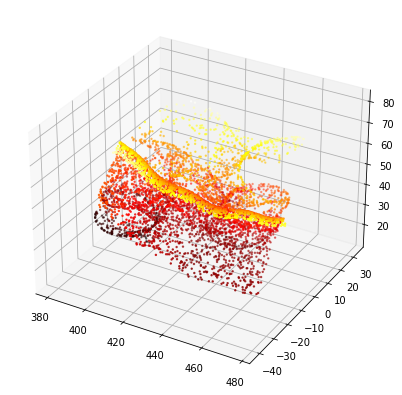

3


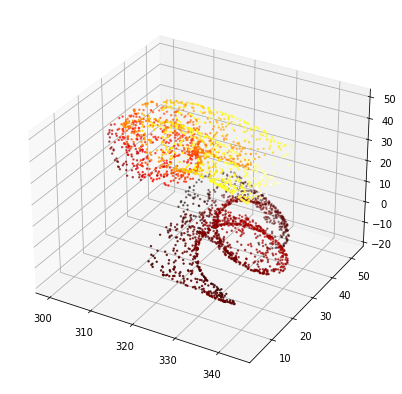

4


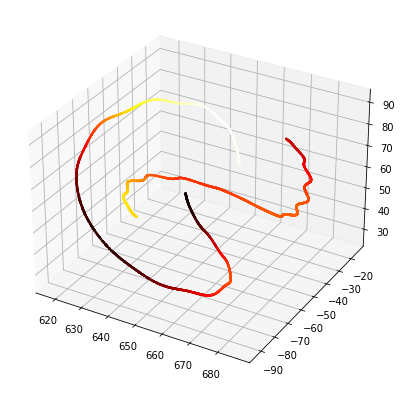

5


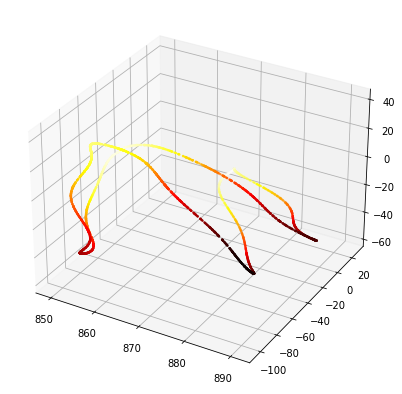

6


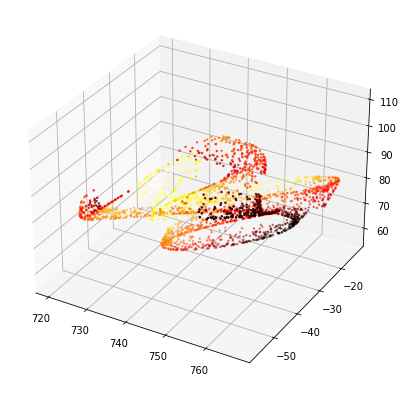

7


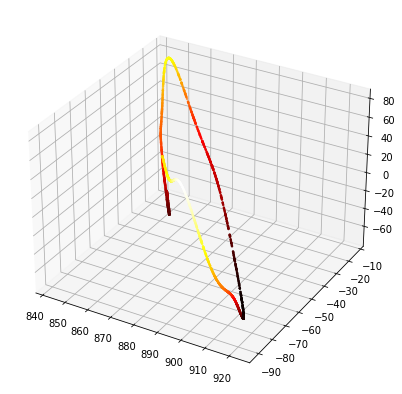

8


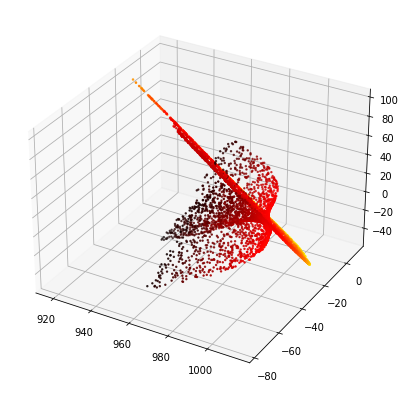

9


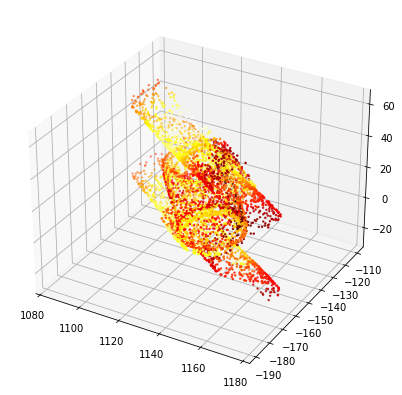

10


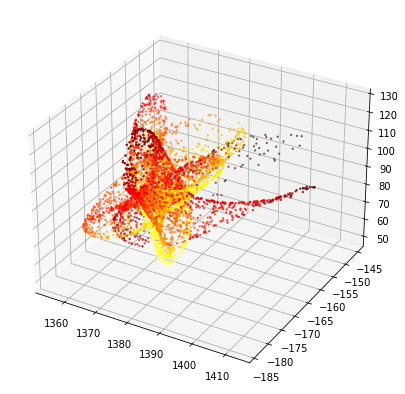

11


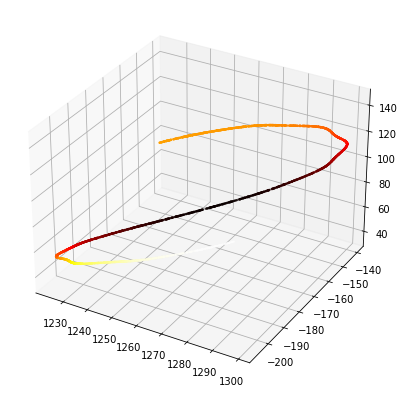

12


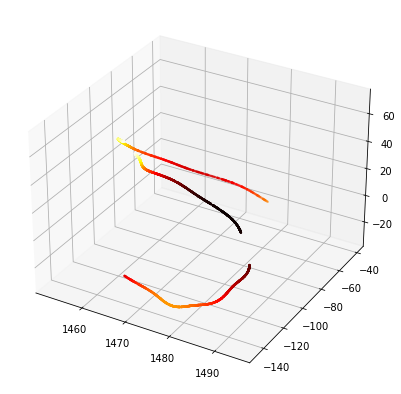

13


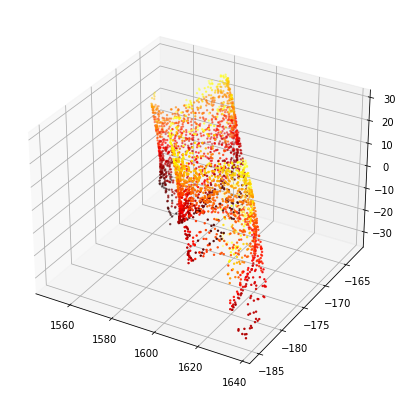

14


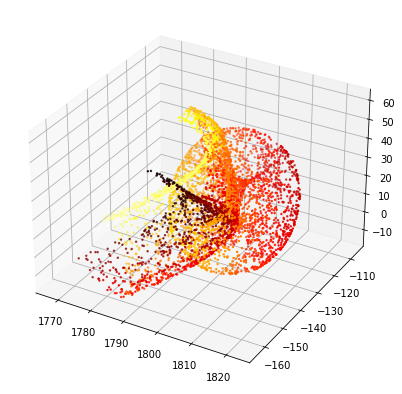

15


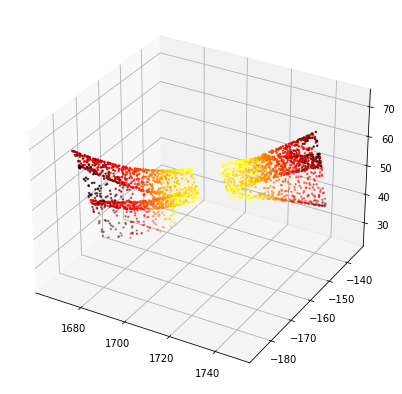

16


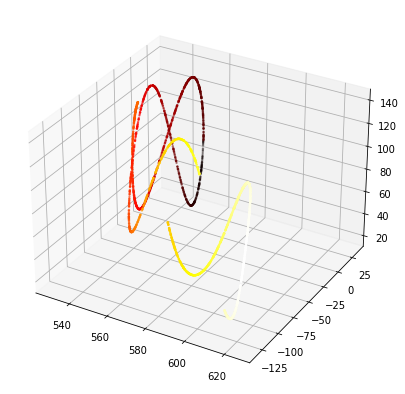

17


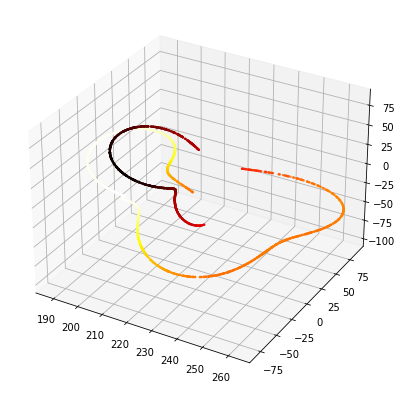

18


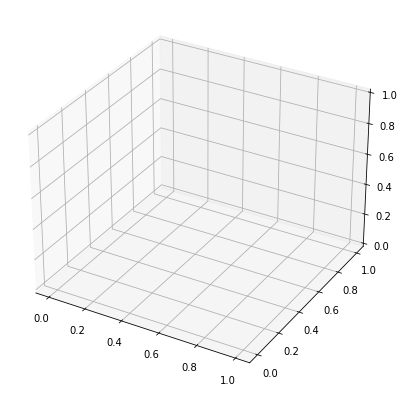

19


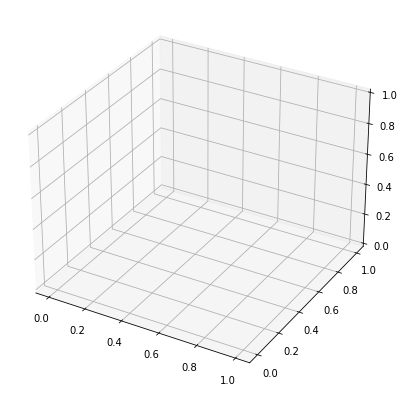

20


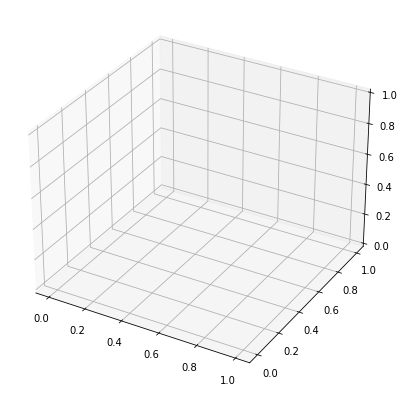

21


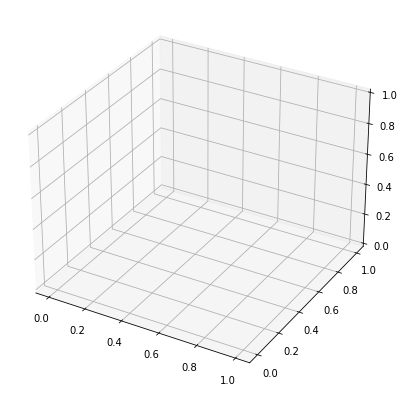

22


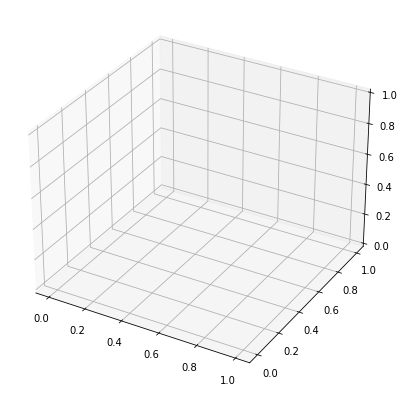

23


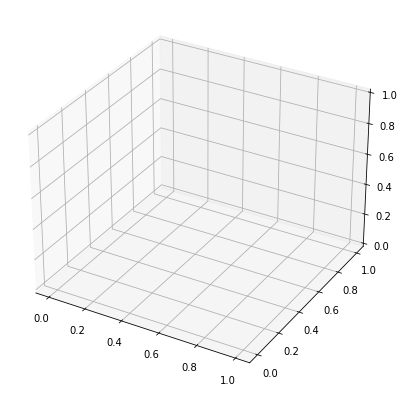

24


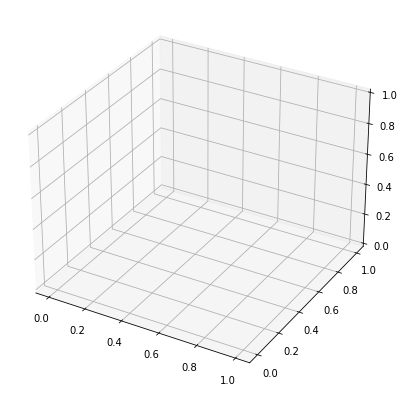

----------------------
0


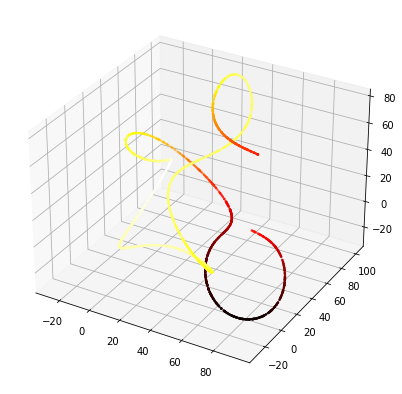

1


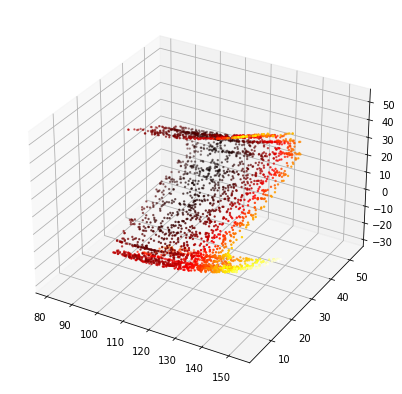

2


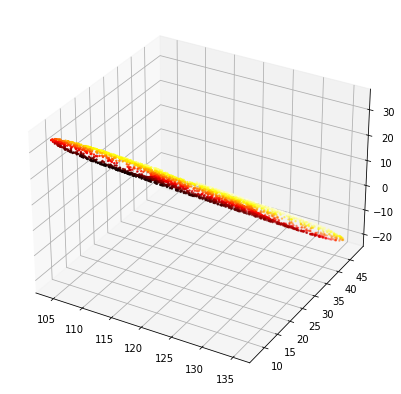

3


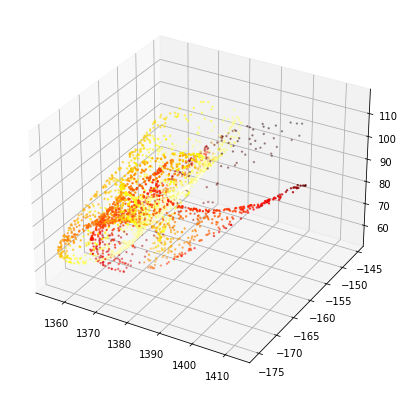

4


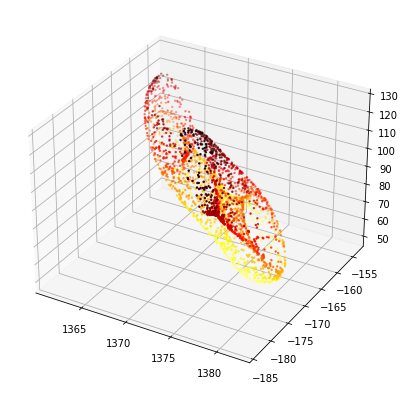

5


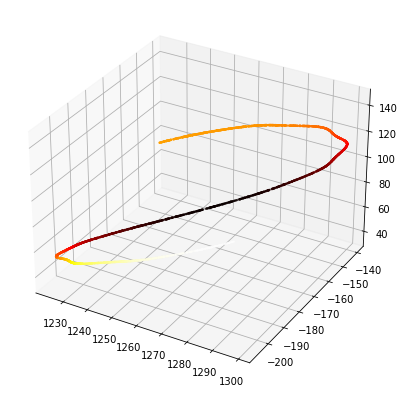

6


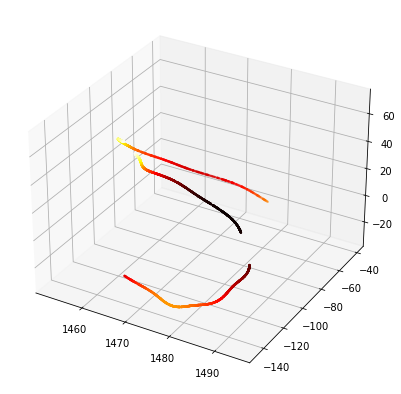

7


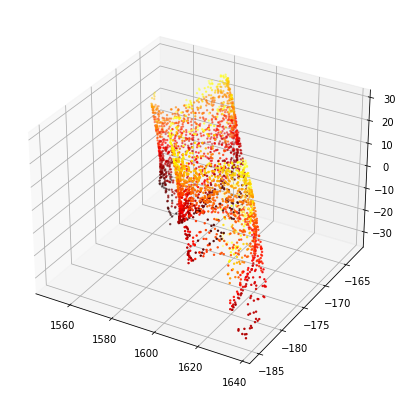

8


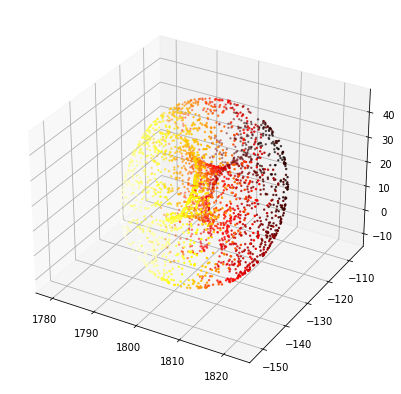

9


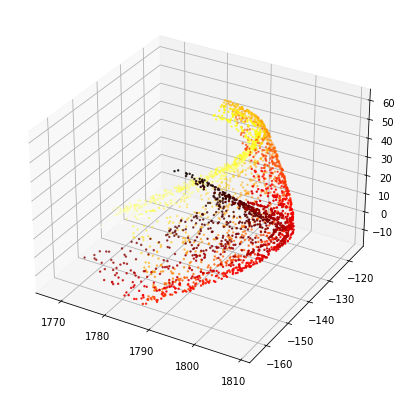

10


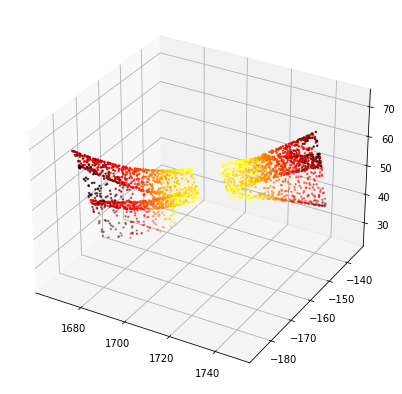

11


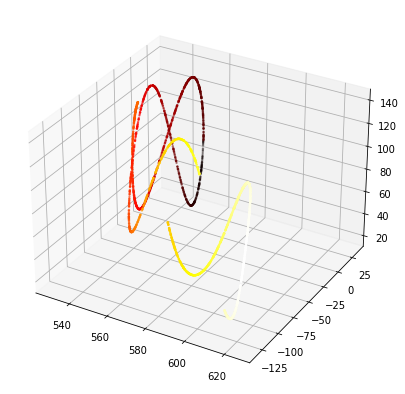

12


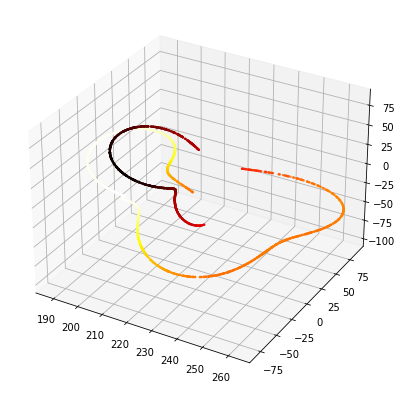

13


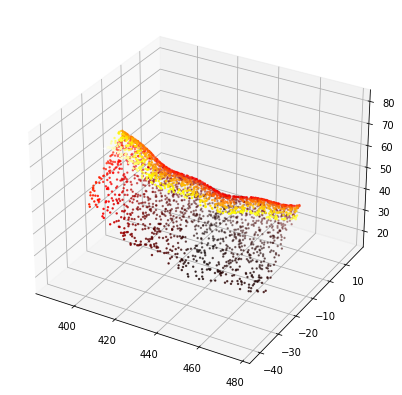

14


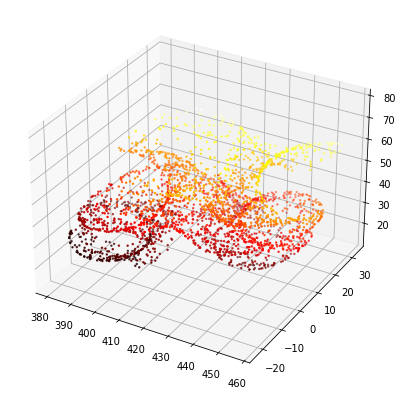

15


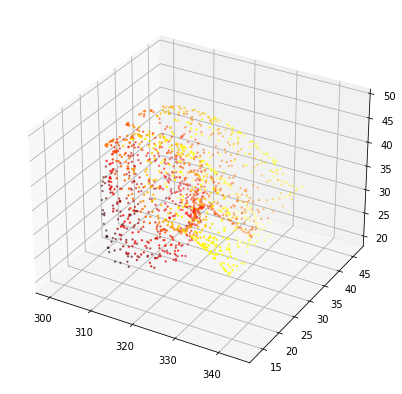

16


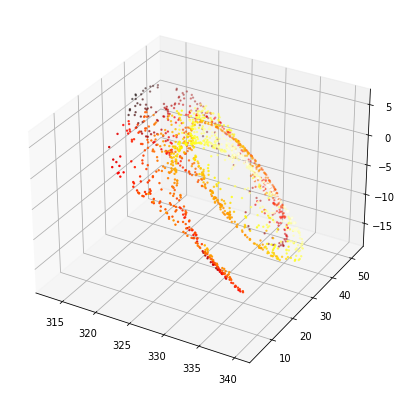

17


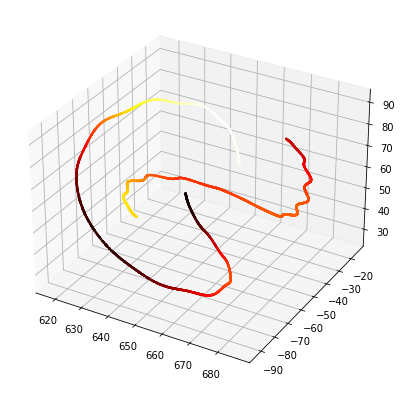

18


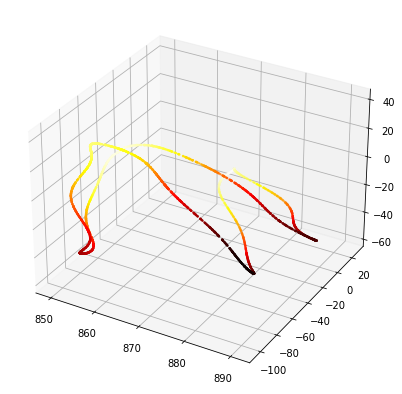

19


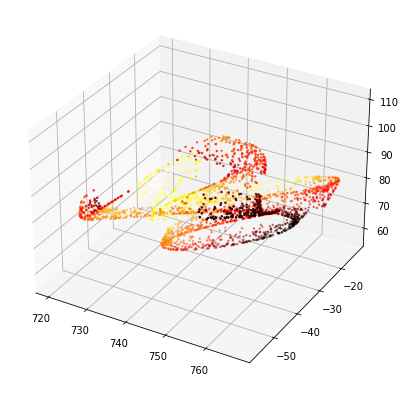

20


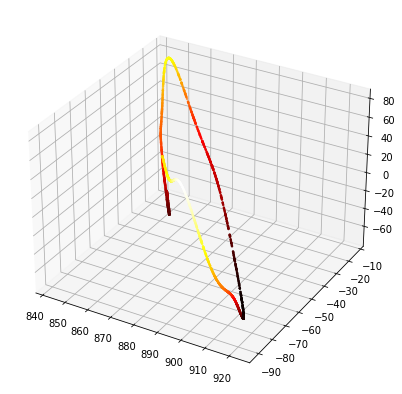

21


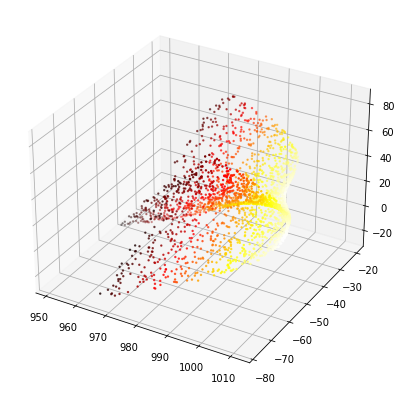

22


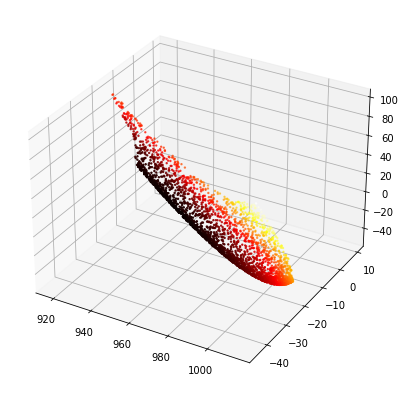

23


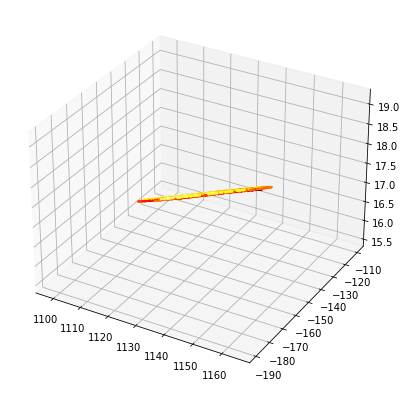

24


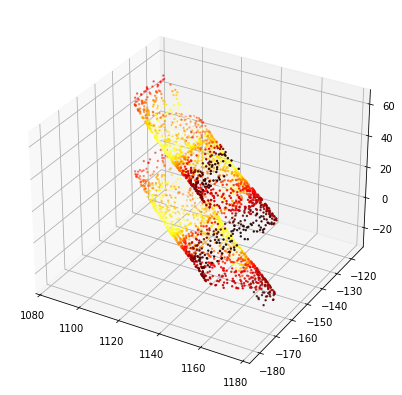

In [5]:
%matplotlib inline
lines = [[16, 15, 11, 9, 8, 7, 6, 3, 2, 0]]
l2 = [15, 11, 9, 8, 7, 6, 3, 2]
tmp = df.copy()
tmp = merge(tmp, 'manifold', [(7, 8), (2, 3)])

for i in range(m):
  print(i)
  visualize_4d(tmp[(tmp['manifold'] == i)])

for i in [1, 2, 3, 8, 9, 10, 14]: # Manually chosen by visualizing with different reduction methods
  td = 3
  res = pd.DataFrame(LocallyLinearEmbedding(
    n_components=td,
    n_neighbors=10
  ).fit_transform(
    tmp[tmp['manifold'] == i][[j for j in range(d)]]
  ), columns=[i for i in range(td)])
  tmp.loc[tmp['manifold'] == i, 'sub1'] = get_cluster(res, num_cluster=2, cluster_type='HS')
tmp['manifold'] = tmp.manifold.astype(str) + '-' + tmp.sub1.astype(str)
tmp.drop(['sub1'], axis=1)
tmp['manifold'] = LabelEncoder().fit_transform(tmp['manifold'])
tmp['manifold'] -= 1
df = tmp
print('----------------------')
for i in range(m):
  print(i)
  visualize_4d(tmp[(tmp['manifold'] == i)])

In [6]:
# custom cluster for manifold
k3 = [6, 11, 12]
k2 = [3, 10, 17, 19]
final_k_list = [1] * m
for t in k2:
  final_k_list[t] = 2
for t in k3:
  final_k_list[t] = 3
cluster_type = ['HS'] * m
for t in k3:
  cluster_type[t] = 'H'
cluster_type[3] = 'custom50'
cluster_type[10] = 'custom'
cluster_type[11] = 'custom3d'
cluster_type[19] = 'custom'

In [7]:
# Joining the cluster labeling
def join_clusters():
  df['cluster'] = [0]*n
  data_index = [0] * m
  for i in range(n):
    index_manifold = df.at[i,'manifold']
    if index_manifold!=-1:
      df.at[i,'cluster'] = list_labels[index_manifold][data_index[index_manifold]]
      data_index[index_manifold]+=1

single_run = None
list_labels = []
for i in range(m):
  print(i)
  labels = get_cluster(df[df['manifold'] == i][[i for i in range(d)]], num_cluster=final_k_list[i], cluster_type=cluster_type[i])
  list_labels.append(labels)
join_clusters()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


0
1
[0.9999990894054933, 0.9999882383768186]


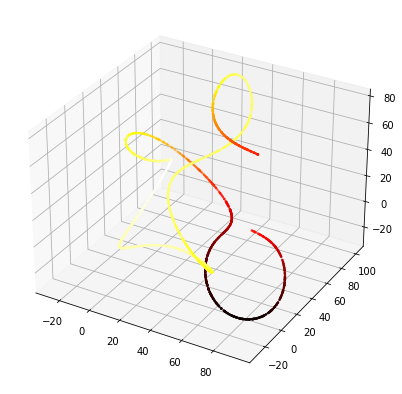

1
2
[0.8560732328012524, 0.9899431483667049]


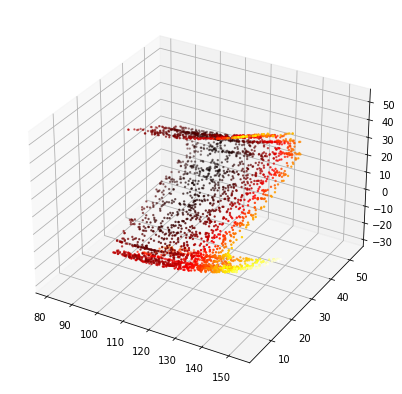

In [8]:
%matplotlib inline
plt.close('all')
D = [1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2]
for i in range(2):
  print(i)
  print(D[i])
  getIntrinsicDimension(df[df['manifold'] == i][[j for j in range(d)]])
  visualize_4d(df[df['manifold'] == i])

### Output

In [9]:
# Outputting

vectors = [[[] for j in range(0,final_k_list[i])] for i in range(0,m)]
#df.loc[df['column_name'] == some_value]
outliar = []
for i in range(n):
  if df.at[i, 'manifold'] == -1:
    outliar.append(i + 1)
  else:
    vectors[df.at[i, 'manifold']][df.at[i, 'cluster']].append(i + 1)

with open('./output.txt', 'w') as f:
  print(f'{n} {m}', file=f)
  for i in range(m):
    dimension = D[i]
    print(f'{dimension} ' + str(final_k_list[i]) + ' Complex', file=f)
    for j in range(0,final_k_list[i]):
      print(str(len(vectors[i][j])) + ' ' + ' '.join(list(map(str, vectors[i][j]))), file=f)
  print(str(len(outliar)) + ' ' + ' '.join(list(map(str, outliar))), file=f)

